# 자연어와 단어의 분산 표현

### 1. 단어의 의미
우리의 말은 '문자'로 말의 의미는 '단어'로 구성, 단어의 의미를 이해 시키는 것이 이번 장에 목적
- 시소러스를 활용한 기법
- 통계기반 기법
- 추론기반 기법(word2vec과 같은)

### 2. 시소러스
시소러스란 (기본적으로는) 유의어 사전으로, '뜻이 같은 단어(동의어)'나 '뜻이 비슷한 단어(유의어)'가 한그룹으로 분류되어 있음. 또한 자연어처리에 활용되는 시소러스에서는 단어 사이의 '상위와 하위', '전체와 부분' 등 더 세세한 정의가 포함되기도 함

- 가장 유명한 시소러스는 WordNet
    - 1985년 구축을 시작, 지금까지 많은 연구와 다양한 어플리케이션에 활용
- 시소러스에 문제점
    - 사람이 수작업으로 레이블링하는 방식에 크나큰 결점이 존재함
    - 시대변화에 적응이 어려움 (신조어 등)
    - 사람을 쓰는 비용이 큼
    - 단어의 미묘한 차이를 표현 불가 (빈티지와 레트로의 차이)

### 3. 통계기반 기법
통계기반 기법의 목표는 사람의 지식으로 가득한 말뭉치(corpus)에서 자동으로, 그리고 효율적으로 그 핵심을 추출하는 것

In [6]:
text = "You say goodbye and I say hello."

# 텍스트 전처리
text = text.lower()
text = text.replace('.', ' .')
text

'you say goodbye and i say hello .'

In [7]:
# 단어로 분할
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [8]:
word2id = {}
id2word = {}

for word in words:
    if word not in word2id:
        new_id = len(word2id)
        word2id[word] = new_id
        id2word[new_id] = word

print(id2word)
print(word2id)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [9]:
import numpy as np

corpus = [word2id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [10]:
# 전처리 함수
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word2id = {}
    id2word = {}
    for word in words:
        if word not in word2id:
            new_id = len(word2id)
            word2id[word] = new_id
            id2word[new_id] = word
            
    corpus = [word2id[w] for w in words]
    
    return corpus, word2id, id2word

text = "You say goodbye and I say hello."
corpus, word2id, id2word = preprocess(text)

#### 단어의 분산 표현
'단어의 의미'를 정확하게 파악 할 수 있는 벡터 표현, 이를 자연어 처리에서는 분산표현이라 함

#### 분포가설
단어를 벡터로 바꾸는 연구는 수도 없이 이루어지며 그 뿌리는 '단어의 의미는 주변 단어에 의해 형성된다' 라는 것. 이를 분포가설이라 함. 이는 단어 자체에는 의미가 없고 그 단어가 사용되는 맥락이 의미를 형성한다는 것을 뜻함

#### 동시발생 행렬
어떤 단어에 주목 했을 때, 그 주변에 어떤 단어가 몇 번이나 등장하는지를 세어 집게하는 것. 이를 통계기반 기법으로 함

In [11]:
# 동시발생 행렬 제작 함수
def creat_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - 1
            right_idx = idx + 1
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

#### 벡터 간 유사도
코사인 유사도를 사용

In [12]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx, ny)

In [13]:
text = "You say goodbye and I say hello."
corpus, word2id, id2word = preprocess(text)
vocab_size = len(word2id)
C = creat_co_matrix(corpus, vocab_size)

c0 = C[word2id['you']]
c1 = C[word2id['i']]
print(cos_similarity(c0, c1))

0.7071067691154799


#### 유사 단어의 랭킹 표시
검색어와 비슷한 단어를 유사도 순으로 출력 구현

In [14]:
def most_similar(query, word2id, id2word, word_matrix, top=5):
    # 검색어를 꺼냄
    if query not in word2id:
        print('%s not find' %query)
        return
    
    print('/n[query] ' + query)
    query_id = word2id[query]
    query_vec = word_matrix[query_id]
    
    # 코사인 유사도 계산
    vocab_size = len(id2word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1*similarity).argsort():
        if id2word[i] == query:
            continue
        print(' %s: %s' %(id2word[i], similarity))
        
        count += 1
        if count >= top:
            return
        
text = "You say goodbye and I say hello."
corpus, word2id, id2word = preprocess(text)
vocab_size = len(word2id)
C = creat_co_matrix(corpus, vocab_size)

most_similar('you', word2id, id2word, C, top=5)

/n[query] you
 goodbye: [0.99999998 0.         0.70710677 0.         0.70710677 0.70710677
 0.        ]
 i: [0.99999998 0.         0.70710677 0.         0.70710677 0.70710677
 0.        ]
 hello: [0.99999998 0.         0.70710677 0.         0.70710677 0.70710677
 0.        ]
 say: [0.99999998 0.         0.70710677 0.         0.70710677 0.70710677
 0.        ]
 and: [0.99999998 0.         0.70710677 0.         0.70710677 0.70710677
 0.        ]


### 4. 통계 기반 기법 개선하기

#### 상호정보량
'발생 횟수'는 좋은 특징이 아님. (ex. 'the', 'car'의 동시발생 횟수는 많지만 의미가 적음) 이러한 문제를 해결하기 위해 점별 상호정보량(PMI) 척도를 사용
- PMI(x,y) = log2(P(x,y)/(P(x)*P(y)))

In [15]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C,  dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / S[j]*S[i] + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100)  == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

text = "You say goodbye and I say hello."
corpus, word2id, id2word = preprocess(text)
vocab_size = len(word2id)
C = creat_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)   ### 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [5.807 0.    4.807 0.    4.807 4.807 0.   ]
 [0.    2.807 0.    3.807 0.    0.    0.   ]
 [0.    0.    3.807 0.    3.807 0.    0.   ]
 [0.    2.807 0.    3.807 0.    0.    0.   ]
 [0.    2.807 0.    0.    0.    0.    4.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


#### 차원감소
중요한 정보는 최대한 유지하면서 벡터의 차원을 감소시킴

In [17]:
text = "You say goodbye and I say hello."
corpus, word2id, id2word = preprocess(text)
vocab_size = len(word2id)
C = creat_co_matrix(corpus, vocab_size)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)
print(C[0])
print(W[0])
print(U[0])
print(U[0, :2])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 0.000e+00  1.748e-01  3.821e-02  0.000e+00  0.000e+00 -9.839e-01
  7.539e-16]
[0.    0.175]


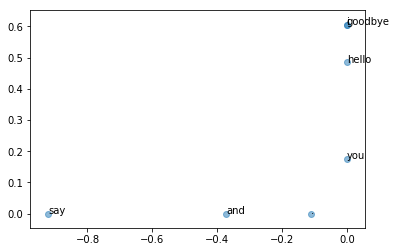

In [19]:
import matplotlib.pyplot as plt

for word, word_id in word2id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()